<a id='top'></a><a name='top'></a>
# Preprocessing data with TensorFlow Transform (Advanced)

[Source](https://www.tensorflow.org/tfx/tutorials/transform/census)

1. [Setup](#setup)
2. [Introduction](#2.0)
3. [What we're doing in this example](#3.0)
    * [3.1 Name our columns](#3.1)
    * [3.2 Define our features and schema](#3.2)
    * [3.3 [Optional] Encode and decode tf.train.Example protos](#3.3)
    * [3.4 Setting hyperparameters and basic housekeeping](#3.4)
4. [Preprocessing with tf.Transform](#4.0)
    * [4.1 Create a tf.Transform preprocessing_fn](#4.1)
5. [Syntax](#5.0)
    * [5.1 Transform the data](#5.1)
6. [Using our preprocessed data to train a model using tf.keras](#6.0)
    * [6.1 Create an input function for training](#6.1)
    * [6.2 Train, Evaluate the model](#6.2)
    * [6.3 Transform new data](#6.3)
    * [6.4 Export the model](#6.4)
7. [What we did](#7.0)

---
<a id='setup'></a><a name='setup'></a>
# 1. Setup
<a href="#top">[back to top]</a>

In [70]:
!rm -r chp13_tfx
!rm -r chp13_tfx_output

In [71]:
import sys

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print("Running on Colab. Installing TFT.")
    !pip install tensorflow-transform
    !apt-get install tree &> /dev/null
    # !pip install protobuf==3.19.0
else:
    print("Running locally.")

Running locally.


In [72]:
import math
import sys
import pathlib
import pprint
pp = pprint.PrettyPrinter(indent=2)
import tempfile

import tensorflow as tf
import tensorflow_transform as tft
import apache_beam as beam

# Module level imports for tensorflow_transform.beam.
# https://github.com/tensorflow/transform/blob/master/tensorflow_transform/beam/__init__.py
# https://www.tensorflow.org/tfx/transform/api_docs/python/tft_beam
import tensorflow_transform.beam as tft_beam

# In-memory representation of all metadata associated with a dataset.
# https://www.tensorflow.org/tfx/transform/api_docs/python/tft/DatasetMetadata
# https://github.com/tensorflow/transform/blob/master/tensorflow_transform/tf_metadata/dataset_metadata.py
from tensorflow_transform.tf_metadata import dataset_metadata

# Utilities for using the tf.Metadata Schema within TensorFlow
# https://github.com/tensorflow/transform/blob/master/tensorflow_transform/tf_metadata/schema_utils.py
from tensorflow_transform.tf_metadata import schema_utils

from tfx_bsl.public import tfxio
from tfx_bsl.coders.example_coder import RecordBatchToExamples


import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)

# global seed
tf.random.set_seed(42)

tf.get_logger().propagate = False
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR') # DEBUG, INFO, WARN, ERROR, or FATAL

def HR():
    print("-"*40)
    
def dir_ex(obj):
    result = [x for x in dir(obj) if not x.startswith('_')]
    print(type(obj))
    print()
    for x in result:
        print(f'{x:<40}', end="")
        
print("Loaded libraries.")

Loaded libraries.


---
<a id='2.0'></a><a name='2.0'></a>
# 2. Introduction
<a href="#top">[back to top]</a>

**The Feature Engineering Component of TensorFlow Extended (TFX)**

This example colab notebook provides a more advanced example of how TensorFlow Transform `(tf.Transform)` can be used to preprocess data using exactly the same code for both training a model and serving inferences in production.

TensorFlow Transform is a library for preprocessing input data for TensorFlow, including creating features that require a full pass over the training dataset. For example, using TensorFlow Transform, you could:

* Normalize an input data by using the mean and standard deviation.
* Convert strings to integers by generating a vocabulary over all of the input values.
* Convert floats to integers by assigning them to buckets, based on the observed data distribution.

TensorFlow has built-in support for manipulations on a single example or a batch of example. `tf.Transform` extends these capabilities to support full passes over the entire training dataset.

The output of `tf.Transform` is exported as a TensorFlow graph, which you can use for both training and serving. Using the same graph for both training and serving can prevent skew, since the same transformations are applied in both stages.

## Transform library for TFX and non-TFX users 

The `tft` module documentation is the only module that is relevant to TFX users. The `tft_beam` module is relevant only when using Transform as a standalone library. Typically, a TFX user constructs a `preprocessing_fn`, and the rest of the Transform library calls are made by the [TFX Transform component](https://www.tensorflow.org/tfx/guide/transform).

---
<a id='3.0'></a><a name='3.0'></a>
# 3. What we're doing in this example
<a href="#top">[back to top]</a>

In this example we'll be processing a widely used dataset containing census data, and training a model to do classification. Along the way we'll be transforming the data using `tf.Transform`.

---
Next, download the data files:

In [73]:
# If you want to start with a clean project:
#!rm -fr chp13_tfx

In [74]:
from pathlib import Path

# Define absolute path and pass to tf.keras.utils.get_file()
data_dir = Path('./chp13_tfx').absolute()

# https://github.com/keras-team/keras/blob/v2.9.0/keras/utils/data_utils.py#L149-L310
# @keras_export('keras.utils.get_file')
train_path = tf.keras.utils.get_file(
    'adult.data',
    'https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/census/adult.data',
    cache_subdir=data_dir
)
test_path = tf.keras.utils.get_file(
    'adult.test',
    'https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/census/adult.test',
    cache_subdir=data_dir
)

2015232/2003153 [==============================] - 0s 0us/step


<a id='3.1'></a><a name='3.1'></a>
## 3.1 Name our columns
<a href="#top">[back to top]</a>

Create some useful lists for referencing the columns in our dataset.

Unlike Pandas, we have to do this manually.

In [75]:
CATEGORICAL_FEATURE_KEYS = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country'
]

NUMERIC_FEATURE_KEYS = [
    'age',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'education-num'
]

ORDERED_CSV_COLUMNS = [
    'age', 
    'workclass', 
    'fnlwgt', 
    'education', 
    'education-num',
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex',
    'capital-gain', 
    'capital-loss', 
    'hours-per-week', 
    'native-country', 
    'label'
]

LABEL_KEY = 'label'

In [76]:
# Experiment:
# tf.data.experimental.make_csv_dataset
# https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset

test_batches = tf.data.experimental.make_csv_dataset(
    train_path,
    batch_size=256, # default: 1024
    shuffle_buffer_size=1000, # default is 10_000
    label_name="label",
    shuffle_seed=42,
    header=False,
    column_names=ORDERED_CSV_COLUMNS
)

print(test_batches.cardinality())

# iterator = test_batches.as_numpy_iterator()
# print(next(iterator))

tf.Tensor(-2, shape=(), dtype=int64)


---
Here's a quick preview of the data:

In [77]:
pandas_train = pd.read_csv(train_path, header=None, names=ORDERED_CSV_COLUMNS)
pandas_train.head(3).T

,0,1,2
age,39,50,38
workclass,State-gov,Self-emp-not-inc,Private
fnlwgt,77516,83311,215646
education,Bachelors,Bachelors,HS-grad
education-num,13,13,9
marital-status,Never-married,Married-civ-spouse,Divorced
occupation,Adm-clerical,Exec-managerial,Handlers-cleaners
relationship,Not-in-family,Husband,Not-in-family
race,White,White,White
sex,Male,Male,Male


In [78]:
pandas_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  label           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [79]:
one_row = dict(pandas_train.loc[0])
one_row

{'age': 39,
 'workclass': ' State-gov',
 'fnlwgt': 77516,
 'education': ' Bachelors',
 'education-num': 13,
 'marital-status': ' Never-married',
 'occupation': ' Adm-clerical',
 'relationship': ' Not-in-family',
 'race': ' White',
 'sex': ' Male',
 'capital-gain': 2174,
 'capital-loss': 0,
 'hours-per-week': 40,
 'native-country': ' United-States',
 'label': ' <=50K'}

In [80]:
# Assign '' for string, otherwise 0.0, for column defaults
# We use this later with tf.data.experimental.make_csv_dataset
COLUMN_DEFAULTS = [
    '' if isinstance(v, str) else 0.0
    for v in dict(pandas_train.loc[1]).values()
]
COLUMN_DEFAULTS

[0.0, '', 0.0, '', 0.0, '', '', '', '', '', 0.0, 0.0, 0.0, '', '']

---
The test data has 1 header line that needs to be skipped, and a trailing "." at the end of each line.

In [81]:
pandas_test = pd.read_csv(test_path, header=1, names=ORDERED_CSV_COLUMNS)
pandas_test.head(3).T

,0,1,2
age,38,28,44
workclass,Private,Local-gov,Private
fnlwgt,89814,336951,160323
education,HS-grad,Assoc-acdm,Some-college
education-num,9,12,10
marital-status,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse
occupation,Farming-fishing,Protective-serv,Machine-op-inspct
relationship,Husband,Husband,Husband
race,White,White,Black
sex,Male,Male,Male


In [82]:
testing = os.getenv("WEB_TEST_BROWSER", False)
print(testing)

# Use a very short, 2-line dataset for testing)
if testing:
    pandas_train = pandas_train.loc[:1]
    pandas_test = pandas_test.loc[:1]
else:
    # If used testing, need to switch back
    pandas_train = pd.read_csv(train_path, header=None, names=ORDERED_CSV_COLUMNS)
    pandas_test = pd.read_csv(test_path, header=1,names=ORDERED_CSV_COLUMNS)

HR()

pandas_train.info()

False
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  label           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


<a id='3.2'></a><a name='3.2'></a>
## 3.2 Define our features and schema
<a href="#top">[back to top]</a>

Define a schema based on what types the columns are in our input. Among other things this will help with importing them correctly.

In [83]:
# Very clean to wrap inside a dict()
RAW_DATA_FEATURE_SPEC = dict(
    [(name, tf.io.FixedLenFeature([], tf.string))
        for name in CATEGORICAL_FEATURE_KEYS] 
    +
    [(name, tf.io.FixedLenFeature([], tf.float32))
        for name in NUMERIC_FEATURE_KEYS] 
    +
    [(LABEL_KEY, tf.io.FixedLenFeature([], tf.string))]
)

RAW_DATA_FEATURE_SPEC

{'workclass': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'education': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'marital-status': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'occupation': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'relationship': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'race': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'sex': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'native-country': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'capital-gain': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'capital-loss': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'hours-per-week': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'education-num': FixedLenFeature(shape=[], dtype=tf

In [84]:
SCHEMA = tft.tf_metadata.dataset_metadata.DatasetMetadata(
    tft.tf_metadata.schema_utils.schema_from_feature_spec(
        RAW_DATA_FEATURE_SPEC
    )
).schema # select the '_schema' key

SCHEMA

feature {
  name: "age"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "capital-gain"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "capital-loss"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "education"
  type: BYTES
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "education-num"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "hours-per-week"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "label"
  type: BYTES
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "marital-status"
  type: BYTES
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "native-country"
  type: BYTES
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "occupation"
  type: BYTES
  presence {
    min_fraction: 1.0
  }
  shape {


<a id='3.3'></a><a name='3.3'></a>
## 3.3 [Optional] Encode and decode tf.train.Example protos
<a href="#top">[back to top]</a>

This tutorial needs to convert examples from the dataset to and from `tf.train.Example` protos.

The `encode_example` function below converts a dictionary of features from the dataset to a `tf.train.Example`.


In [85]:
def encode_example(input_features):
    input_features = dict(input_features)
    output_features = {}
    
    for key in CATEGORICAL_FEATURE_KEYS:
        value = input_features[key]
        feature = tf.train.Feature(
            bytes_list = tf.train.BytesList(value=[value.strip().encode()])
        )
        output_features[key] = feature
        
    for key in NUMERIC_FEATURE_KEYS:
        value = input_features[key]
        feature = tf.train.Feature(
            float_list = tf.train.FloatList(value=[value]))
        output_features[key] = feature 

    label_value = input_features.get(LABEL_KEY, None)
    if label_value is not None:
        output_features[LABEL_KEY] = tf.train.Feature(
            bytes_list = tf.train.BytesList(value=[label_value.strip().encode()]))

    example = tf.train.Example(
      features = tf.train.Features(feature=output_features)
    )
    return example

---
Now we can convert the dataset example into `Example` protos.

In [86]:
tf_example = encode_example(pandas_train.loc[0])
tf_example.features.feature['age']

float_list {
  value: 39.0
}

In [87]:
serialized_example_batch = tf.constant([
    encode_example(pandas_train.loc[i]).SerializeToString()
    for i in range(3)
])

print(serialized_example_batch) # type EagerTensor

tf.Tensor(
[b'\n\xf9\x02\n#\n\x0enative-country\x12\x11\n\x0f\n\rUnited-States\n\x11\n\x04race\x12\t\n\x07\n\x05White\n#\n\x0emarital-status\x12\x11\n\x0f\n\rNever-married\n\x1a\n\teducation\x12\r\n\x0b\n\tBachelors\n\x12\n\x05label\x12\t\n\x07\n\x05<=50K\n\x18\n\x0ccapital-gain\x12\x08\x12\x06\n\x04\x00\xe0\x07E\n\x0f\n\x03sex\x12\x08\n\x06\n\x04Male\n\x18\n\x0ccapital-loss\x12\x08\x12\x06\n\x04\x00\x00\x00\x00\n\x19\n\reducation-num\x12\x08\x12\x06\n\x04\x00\x00PA\n\x1a\n\tworkclass\x12\r\n\x0b\n\tState-gov\n\x0f\n\x03age\x12\x08\x12\x06\n\x04\x00\x00\x1cB\n\x1a\n\x0ehours-per-week\x12\x08\x12\x06\n\x04\x00\x00 B\n!\n\x0crelationship\x12\x11\n\x0f\n\rNot-in-family\n\x1e\n\noccupation\x12\x10\n\x0e\n\x0cAdm-clerical'
 b'\n\x82\x03\n#\n\x0enative-country\x12\x11\n\x0f\n\rUnited-States\n\x1a\n\x0ehours-per-week\x12\x08\x12\x06\n\x04\x00\x00PA\n\x18\n\x0ccapital-loss\x12\x08\x12\x06\n\x04\x00\x00\x00\x00\n\x18\n\x0ccapital-gain\x12\x08\x12\x06\n\x04\x00\x00\x00\x00\n\x1b\n\x0crelationshi

---
You can also convert batches of serialized Example protos back into a dictionary of tensors.

In [88]:
decoded_tensors = tf.io.parse_example(
    serialized_example_batch,
    features=RAW_DATA_FEATURE_SPEC
)

decoded_tensors['age']

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([39., 50., 38.], dtype=float32)>

---
In some cases, the label will not be passed in, so the encode function is written so that the label is optional:

In [89]:
features_dict = dict(pandas_train.loc[0])
features_dict.pop(LABEL_KEY)

LABEL_KEY in features_dict

False

<a id='3.4'></a><a name='3.4'></a>
## 3.4 Setting hyperparameters and basic housekeeping
<a href="#top">[back to top]</a>

Constants and hyperparameters used for training.

In [90]:
from dataclasses import dataclass, field 

# A field is defined as a class variable that has a type annotation
# Default for dataclasses.field:
# (*, default=MISSING, default_factory=MISSING, repr=True, hash=None, init=True, compare=True, metadata=None)

# fields may optionally specify a default value, using normal Python syntax:

@dataclass
class HP:
    NUM_TRAIN_INSTANCES: int
    BATCH_SIZE: int
    EPOCH_SPLITS: int    
    
    NUM_OOV_BUCKETS: int
    EPOCH_SPLITS: int
    TRAIN_NUM_EPOCHS: object
    NUM_TRAIN_INSTANCES: int
    NUM_TEST_INSTANCES: int
    BATCH_SIZE: int
    
    TRANSFORMED_TRAIN_DATA_FILEBASE: str
    TRANSFORMED_TEST_DATA_FILEBASE: str
    EXPORTED_MODEL_DIR: str
   
    # Computed-properties: need to mark as exempt from __init__ arguments
    TRAIN_NUM_EPOCHS: int = field(init=False)
    STEPS_PER_TRAIN_EPOCH: int = field(init=False) 
    EVALUATION_STEPS: int = field(init=False)
    
    # Computed-properties: provide definition via __post__init__()
    def __post_init__(self):
        self.TRAIN_NUM_EPOCHS =  2*self.EPOCH_SPLITS
        self.STEPS_PER_TRAIN_EPOCH = tf.math.ceil(self.NUM_TRAIN_INSTANCES/self.BATCH_SIZE/self.EPOCH_SPLITS)
        self.EVALUATION_STEPS = tf.math.ceil(self.NUM_TEST_INSTANCES/self.BATCH_SIZE)
    
    
hp = HP(
    NUM_OOV_BUCKETS = 1,
    EPOCH_SPLITS = 10,
    NUM_TRAIN_INSTANCES = len(pandas_train),
    NUM_TEST_INSTANCES = len(pandas_test),
    BATCH_SIZE = 128,

    # Names of temp files
    TRANSFORMED_TRAIN_DATA_FILEBASE = 'train_transformed',
    TRANSFORMED_TEST_DATA_FILEBASE = 'test_transformed',
    EXPORTED_MODEL_DIR = 'exported_model_dir',
)

print(type(hp.TRAIN_NUM_EPOCHS), hp.TRAIN_NUM_EPOCHS)
print(type(hp.STEPS_PER_TRAIN_EPOCH), hp.STEPS_PER_TRAIN_EPOCH)
print(type(hp.EVALUATION_STEPS), hp.EVALUATION_STEPS)

<class 'int'> 20
<class 'tensorflow.python.framework.ops.EagerTensor'> tf.Tensor(26.0, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'> tf.Tensor(128.0, shape=(), dtype=float32)


In [91]:
if testing:
    TRAIN_NUM_EPOCHS = 1

print(testing)

False


---
<a id='4.0'></a><a name='4.0'></a>
# 4. Preprocessing with tf.Transform
<a href="#top">[back to top]</a>

<a id='4.1'></a><a name='4.1'></a>
## 4.1  Create a tf.Transform preprocessing_fn
<a href="#top">[back to top]</a>

The *preprocessing function* is the most important concept of tf.Transform.

A preprocessing function is where the transformation of the dataset really happens. It accepts and returns a dictionary of tensors, where a tensor means a Tensor or SparseTensor. There are two main groups of API calls that typically form the heart of a preprocessing function:

1. TensorFlow Ops: Any function that accepts and returns tensors, which usually means TensorFlow ops. These add TensorFlow operations to the graph that transform raw data into transformed data, one feature vector at a time. These will run for every example, during both training and serving.

2. Tensorflow Transform Analyzers/Mapper: Any of the analyzers/mappers provided by tf.Transform. These also accept and return tensors, and typically contain a combination of Tensorflow ops and Beam computation, but unlike TensorFlow ops, they only run in the Beam pipeline during analysis requiring a full pass over the entire training dataset. The Beam computation runs only once (prior to training, during analysis), and typically make a full pass over the entire training dataset. They create `tf.constant` tensors, which are added to your graph. For example, `tft.min` computes the minimum of a tensor over the training dataset.

Caution: When you apply your preprocessing function to serving inferences, the constants that were created by analyzers during training do not change. If your data has trend or seasonality components, plan accordingly.

---

Here is a `preprocessing_fn` for this dataset. It does several things:

1. Using `tft.scale_to_0_1`, it scales the numeric features to the `[0,1]` range.
2. Using `tft.compute_and_apply_vocabulary`, it computes a vocabulary for each of the categorical features, and returns the integer IDs for each input as an `tf.int64`. This applies both to string and integer categorical-inputs.
3. It applies some manual transformations to the data using standard TensorFlow operations. Here these operations are applied to the label but could transform the features as well. The TensorFlow operations do several things:
    * They build a lookup table for the label (the `tf.init_scope` ensures that the table is only created the first time the function is called).
    * They normalize the text of the label.
    * They convert the label to a one-hot

In [92]:
def preprocessing_fn(inputs, hp=hp):
    """Preprocess input columns into transformed columns."""
    
    # Since we are modifying some features and leaving others unchanged,
    # we start by setting `outputs` to a copy of `inputs`.
    outputs = inputs.copy()
    
    # Scale numeric columns to have range [0, 1]
    for key in NUMERIC_FEATURE_KEYS:
        outputs[key] = tft.scale_to_0_1(inputs[key])
        
        
    # For all categorical columns except the label column, we generate a
    # vocabulary but do not modify the feature. This vocabulary is instead
    # used in the trainer, by means of a feature column, to convert the
    # feature from a string to an integer id.
    for key in CATEGORICAL_FEATURE_KEYS:
        outputs[key] = tft.compute_and_apply_vocabulary(
            tf.strings.strip(inputs[key]),
            num_oov_buckets = hp.NUM_OOV_BUCKETS,
            vocab_filename=key
        )
    
    
    # For the label column, we provide the mapping from string to index
    table_keys = ['>50K', '<=50K']
    
    # A context manager that lifts ops out of control-flow scopes and function-building graphs.
    with tf.init_scope():
        # Table initializers given keys and values tensors.
        initializer = tf.lookup.KeyValueTensorInitializer(
            keys=table_keys,
            values=tf.cast(tf.range(len(table_keys)), tf.int64),
            key_dtype=tf.string,
            value_dtype=tf.int64
        )
        # generic hash table that is immutable once initialized
        table = tf.lookup.StaticHashTable(initializer, default_value= -1)
    
    
    # Remove trailing periods for test dasta when the data is read with tf.data.
    # label_str = tf.sparse.to_dense(inputs[LABEL_KEY])
    label_str = inputs[LABEL_KEY]
    label_str = tf.strings.regex_replace(label_str, r'\.$', '')
    label_str = tf.strings.strip(label_str)
    data_labels = table.lookup(label_str)
    transformed_label = tf.one_hot(
        indices=data_labels,
        depth=len(table_keys),
        on_value=1.0,
        off_value=0.0
    )
    outputs[LABEL_KEY] = tf.reshape(transformed_label, [-1, len(table_keys)])
    
    return outputs

---
<a id='5.0'></a><a name='5.0'></a>
# 5. Syntax
<a href="#top">[back to top]</a>

We're almost ready to put everything together and use Apache Beam to run it.

Apache Beam uses a special syntax to define and invoke transform:

    result = pass_this 
    | 'name this step' >> to_this_call
    
You will often see stages of a pipeline chained together like this:
    
    result = apache_beam.Pipeline() 
    | 'first_step' >> do_this_first() 
    | 'second_step' >> do_this_last()
    
and since that started with a new pipeline, you can continue like this:

    next_result = result 
    | 'doing more stuff' >> another_function()

<a id='5.1'></a><a name='5.1'></a>
## 5.1 Transform the data
<a href="#top">[back to top]</a>

Now we're ready to start transforming the data in an Apache Beam pipeline.

1. Read in the data using `tfxio.CsvTFXIO` CSV reader. Alternatively, to **manually process lines of text in a pipeline**, use `tfxio.BeamRecordCsvTFXIO` instead.
2. Analyze and transform the data using the `preprocessing_fn` defined above.
3. Write out the result as a `TFRecord` of `Example` protos, which we will use for training a model later.

In [93]:
import tempfile

def transform_data(train_data_file, test_data_file, working_dir, hp=hp):
    """Transform the data and write out as a TFRecord of Example protos.
    
    Read in the data using the CSV reader, and transform it using a
    preprocessing pipeline that scales numeric data and converts categorical
    data from strings to int64 values indices, by creating a vocabulary
    for each category.
    
    Args:
        train_data_file: File containing training data
        test_data_file: File containing test data
        working_dir: Directory to write transformed dasta and metadata to
    """
    
    # The 'with' block will create a pipeline, and run that pipeline at the end of the block.
    with beam.Pipeline() as pipeline:
        
        with tft_beam.Context(temp_dir=tempfile.mkdtemp()):
        
            # Create a TFXIO to read the census data with the schema.
            # To do this, we need to list all columns in order, since 
            # the schema doesn't specify the order of columns in the csv.
            train_csv_tfxio = tfxio.CsvTFXIO(
                file_pattern = train_data_file,
                telemetry_descriptors = [],
                column_names = ORDERED_CSV_COLUMNS,
                schema = SCHEMA
            )
            
            # Read in raw data and convert using CSV TFXIO.
            raw_data = (
                pipeline 
                | 'ReadTrainCsv' >> train_csv_tfxio.BeamSource()
            )
            
            # Combine data and schema into a dataset tuple.
            # Note that we already used the schema to read the CSV data,
            # but we also need it to interpret raw_data.
            cfg = train_csv_tfxio.TensorAdapterConfig()
            raw_dataset = (raw_data, cfg)
            
            # The TFXIO output format is chosen for improved performance
            transformed_dataset, transform_fn = (
                raw_dataset | tft_beam.AnalyzeAndTransformDataset(
                    preprocessing_fn, 
                    output_record_batches=True
                )
            )
            
            # Transformed metadata is not necessary for encoding.
            transformed_data, _ = transformed_dataset
            
            # Extract transformed RecordBatches, encode and write them
            # to the given directory.
            # TODO: Switch to RecordBatchToExampleEncoder
            # 
            # Encodes pa.RecordBatch as a list of serialized tf.Examples.
            # tfx_bsl.public.tfxio.RecordBatchToExamplesEncoder
            # https://www.tensorflow.org/tfx/tfx_bsl/api_docs/python/tfx_bsl/public/tfxio/RecordBatchToExamplesEncoder
            # https://github.com/tensorflow/tfx-bsl/blob/master/tfx_bsl/coders/example_coder.py#L56
            
            _ = (
                transformed_data
                | 'EncodeTrainData' >> beam.FlatMapTuple(lambda batch, _: RecordBatchToExamples(batch))
                | 'WriteTrainData' >> beam.io.WriteToTFRecord(os.path.join(working_dir, hp.TRANSFORMED_TRAIN_DATA_FILEBASE))
            )
            
            # Now, apply transform function to test data. In this case, remove
            # the trailing period at the end of each line, and also ignore
            # the header line that is present in the test data file.
            test_csv_tfxio = tfxio.CsvTFXIO(
                file_pattern = test_data_file,
                skip_header_lines = 1,
                telemetry_descriptors = [],
                column_names = ORDERED_CSV_COLUMNS,
                schema = SCHEMA
            )
            raw_test_data = (
                pipeline
                | 'ReadTestCsv' >> test_csv_tfxio.BeamSource()
            )
            
            raw_test_dataset = (
                raw_test_data,
                test_csv_tfxio.TensorAdapterConfig()
            )
            
            # The TFXIO output format is chosen for improved performance
            transformed_test_dataset = (
                (raw_test_dataset, transform_fn)
                | tft_beam.TransformDataset(output_record_batches=True)
            )
            
            # Transformed metadata is not necessary for encoding
            transformed_test_data, _ = transformed_test_dataset
            
            # Extract transformed RecordBatches, encode and write them to the given directory
            _ = (
                transformed_test_data
                | 'EncodeTestData' >> beam.FlatMapTuple(lambda batch, _ : RecordBatchToExamples(batch))
                | 'WriteTestData' >> beam.io.WriteToTFRecord(os.path.join(working_dir, hp.TRANSFORMED_TEST_DATA_FILEBASE))
            )
            
            # Write a SavedModel and metadata to working_dir, which can then 
            # be read by the tft.TFTransformOutput class.
            _ = (
                transform_fn
                | 'WriteTransformFn' >> tft_beam.WriteTransformFn(working_dir)
            )

---
Run the pipeline:

In [94]:
#!rm -fr chp13_tfx_output

In [95]:
import pathlib

output_dir = os.path.join('chp13_tfx_output')

print("Start..")
transform_data(train_path, test_path, output_dir)
print("Done..")

Start..


Done..


---
Wrap the output directory with `tft.TFTransformOutput`:

In [96]:
# This is not iterable.
# A wrapper around the output of the tf.Transform.
tf_transform_output = tft.TFTransformOutput(output_dir)
tf_transform_output

In [97]:
# Returns a feature_spec for the transformed features
# Returns a dict from feature names to FixedLenFeature/SparseFeature/VarLenFeature.
tf_transform_output.transformed_feature_spec()

{'age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'capital-gain': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'capital-loss': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'education': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'education-num': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'hours-per-week': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'label': FixedLenFeature(shape=[2], dtype=tf.float32, default_value=None),
 'marital-status': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'native-country': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'occupation': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'race': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'relationship': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'sex': FixedLenFeature(shape=[], dtype=tf.int64,

---
If you inspect the output_dir, you can see it contains three things:

1. The `train_transformed` and `test_transformed` data files
2. The `transform_fn` directory (a `tf.saved` model)
3. The `transformed_metadata`

**The following sections show how to use these artifacts to train a model.**

In [98]:
# human readable file sizes, long format.
!ls -lh chp13_tfx_output

total 31392
-rw-r--r--  1 gb  staff   5.1M Jul 28 00:14 test_transformed-00000-of-00001
-rw-r--r--  1 gb  staff    10M Jul 28 00:14 train_transformed-00000-of-00001
drwxr-xr-x  5 gb  staff   160B Jul 28 00:14 transform_fn
drwxr-xr-x  4 gb  staff   128B Jul 28 00:14 transformed_metadata


In [99]:
# human readable file sizes, long format.
!ls -lh chp13_tfx

total 11688
-rw-r--r--  1 gb  staff   3.8M Jul 28 00:14 adult.data
-rw-r--r--  1 gb  staff   1.9M Jul 28 00:14 adult.test


---
<a id='6.0'></a><a name='6.0'></a>
# 6. Using our preprocessed data to train a model using tf.keras
<a href="#top">[back to top]</a>

To show how `tf.Transform` enables us to use the same code for both training and serving, and thus prevent skew, we're going to train a model.

To train our model and prepare our trained model for production, we need to create input functions. The main difference between our training input function and our serving input function is that training data contains **labels**, and production data does not. The arguments and returns are also somewhat different.

<a id='6.1'></a><a name='6.1'></a>
## 6.1 Create an input function for training
<a href="#top">[back to top]</a>

Running the pipeline in the previous section created `TFRecord` files containing the transformed data.

The following code uses `tf.data.experiment.make_batched_features_dataset` and `tft.TFTransformOutput.transformed_feature_spec` to read these data files as a `tf.data.Dataset`.

* Returns a Dataset of feature dictionaries from Example protos.
    - https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_batched_features_dataset
* Returns a feature_spec for the transformed features.
    - https://www.tensorflow.org/tfx/transform/api_docs/python/tft/TFTransformOutput#transformed_feature_spec

In [100]:
def _make_training_input_fn(tf_transform_output, train_file_pattern, batch_size):
    """An input function reading from transformed data,
    converting to model input.
    
    Args:
        tf_transform_output: Wrapper around output of tf.Transform
        transformed_examples: Base filename of examples.
        batch_size: Batch size.
    
    Returns:
        The input data for training or eval, in the form of k.
    """
    def input_fn():
        return tf.data.experimental.make_batched_features_dataset(
            file_pattern=train_file_pattern,
            batch_size=batch_size,
            features=tf_transform_output.transformed_feature_spec(),
            reader=tf.data.TFRecordDataset,
            label_key=LABEL_KEY,
            shuffle=True
        )
        
    return input_fn

In [101]:
train_file_pattern = pathlib.Path(output_dir)/f"{hp.TRANSFORMED_TRAIN_DATA_FILEBASE}*"

input_fn = _make_training_input_fn(
    tf_transform_output=tf_transform_output,
    train_file_pattern=str(train_file_pattern),
    batch_size=10
)

---
Below, we can see a transformed sample of the data.

Note how the numeric columns like `education-num` and `hours-per-week` are converted to floats with a range of `[0,1]`, and the string columns have been converted to `ID`s.

In [102]:
pandas_test.drop(columns='label').sort_index(axis=1).head(3)

,age,capital-gain,capital-loss,education,education-num,fnlwgt,hours-per-week,marital-status,native-country,occupation,race,relationship,sex,workclass
0,38,0,0,HS-grad,9,89814,50,Married-civ-spouse,United-States,Farming-fishing,White,Husband,Male,Private
1,28,0,0,Assoc-acdm,12,336951,40,Married-civ-spouse,United-States,Protective-serv,White,Husband,Male,Local-gov
2,44,7688,0,Some-college,10,160323,40,Married-civ-spouse,United-States,Machine-op-inspct,Black,Husband,Male,Private


In [103]:
for example, label in input_fn().take(1):
    break
pd.DataFrame(example).head(3)

,age,capital-gain,capital-loss,education,education-num,hours-per-week,marital-status,native-country,occupation,race,relationship,sex,workclass
0,0.424658,0.076881,0.0,2,0.800000,0.397959,0,0,3,0,0,0,0
1,0.561644,0.000000,0.0,11,0.466667,0.234694,0,0,5,0,4,1,0
2,0.246575,0.000000,0.0,0,0.533333,0.397959,0,0,1,0,0,0,1


In [104]:
pandas_test[['label']].head(3)

,label
0,<=50K.
1,>50K.
2,>50K.


In [105]:
pd.DataFrame(label).head(3)

,0,1
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0


<a id='6.2'></a><a name='6.2'></a>
## 6.2 Train, Evaluate the model
<a href="#top">[back to top]</a>

Build the model.

In [106]:
def build_keras_model(working_dir):
    # Functional API for model
    inputs = build_keras_inputs(working_dir)
    
    encoded_inputs = encode_inputs(inputs)
    
    stacked_inputs = tf.concat(tf.nest.flatten(encoded_inputs), axis=1)
    output = tf.keras.layers.Dense(100, activation='relu')(stacked_inputs)
    output = tf.keras.layers.Dense(50, activation='relu')(output)
    output = tf.keras.layers.Dense(2)(output)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    return model

In [107]:
def build_keras_inputs(working_dir):
    tf_transform_output = tft.TFTransformOutput(working_dir)
    
    feature_spec = tf_transform_output.transformed_feature_spec().copy()
    feature_spec.pop(LABEL_KEY)
    
    # Build the keras.Input objects
    inputs = {}
    for key, spec in feature_spec.items():
        # Why do we transform a Variable-length feature to sparse tensor?
        if isinstance(spec, tf.io.VarLenFeature):
            inputs[key] = tf.keras.layers.Input(
                shape=[None],
                name=key,
                dtype=spec.dtype,
                sparse=True
            )
        elif isinstance(spec, tf.io.FixedLenFeature):
            inputs[key] = tf.keras.layers.Input(
                shape=spec.shape,
                name=key,
                dtype=spec.dtype
            )
        else:
            raise ValueError('Spec type is not supported: ', key, spec)
    return inputs

In [108]:
def encode_inputs(inputs):
    encoded_inputs = {}
    for key in inputs:
        feature = tf.expand_dims(inputs[key], -1)
        if key in CATEGORICAL_FEATURE_KEYS:
            num_buckets = tf_transform_output.num_buckets_for_transformed_feature(key)
            encoding_layer = (
                tf.keras.layers.CategoryEncoding(
                    num_tokens=num_buckets,
                    output_mode='binary',
                    sparse=False
                )
            )
            encoded_inputs[key] = encoding_layer(feature)
        else:
            # Pass-through?
            encoded_inputs[key] = feature
            
    return encoded_inputs

In [109]:
model = build_keras_model(output_dir)

In [110]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 education (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 marital-status (InputLayer)    [(None,)]            0           []                               
                                                                                                  
 native-country (InputLayer)    [(None,)]            0           []                               
                                                                                                  
 occupation (InputLayer)        [(None,)]            0           []                               
                                                                                            

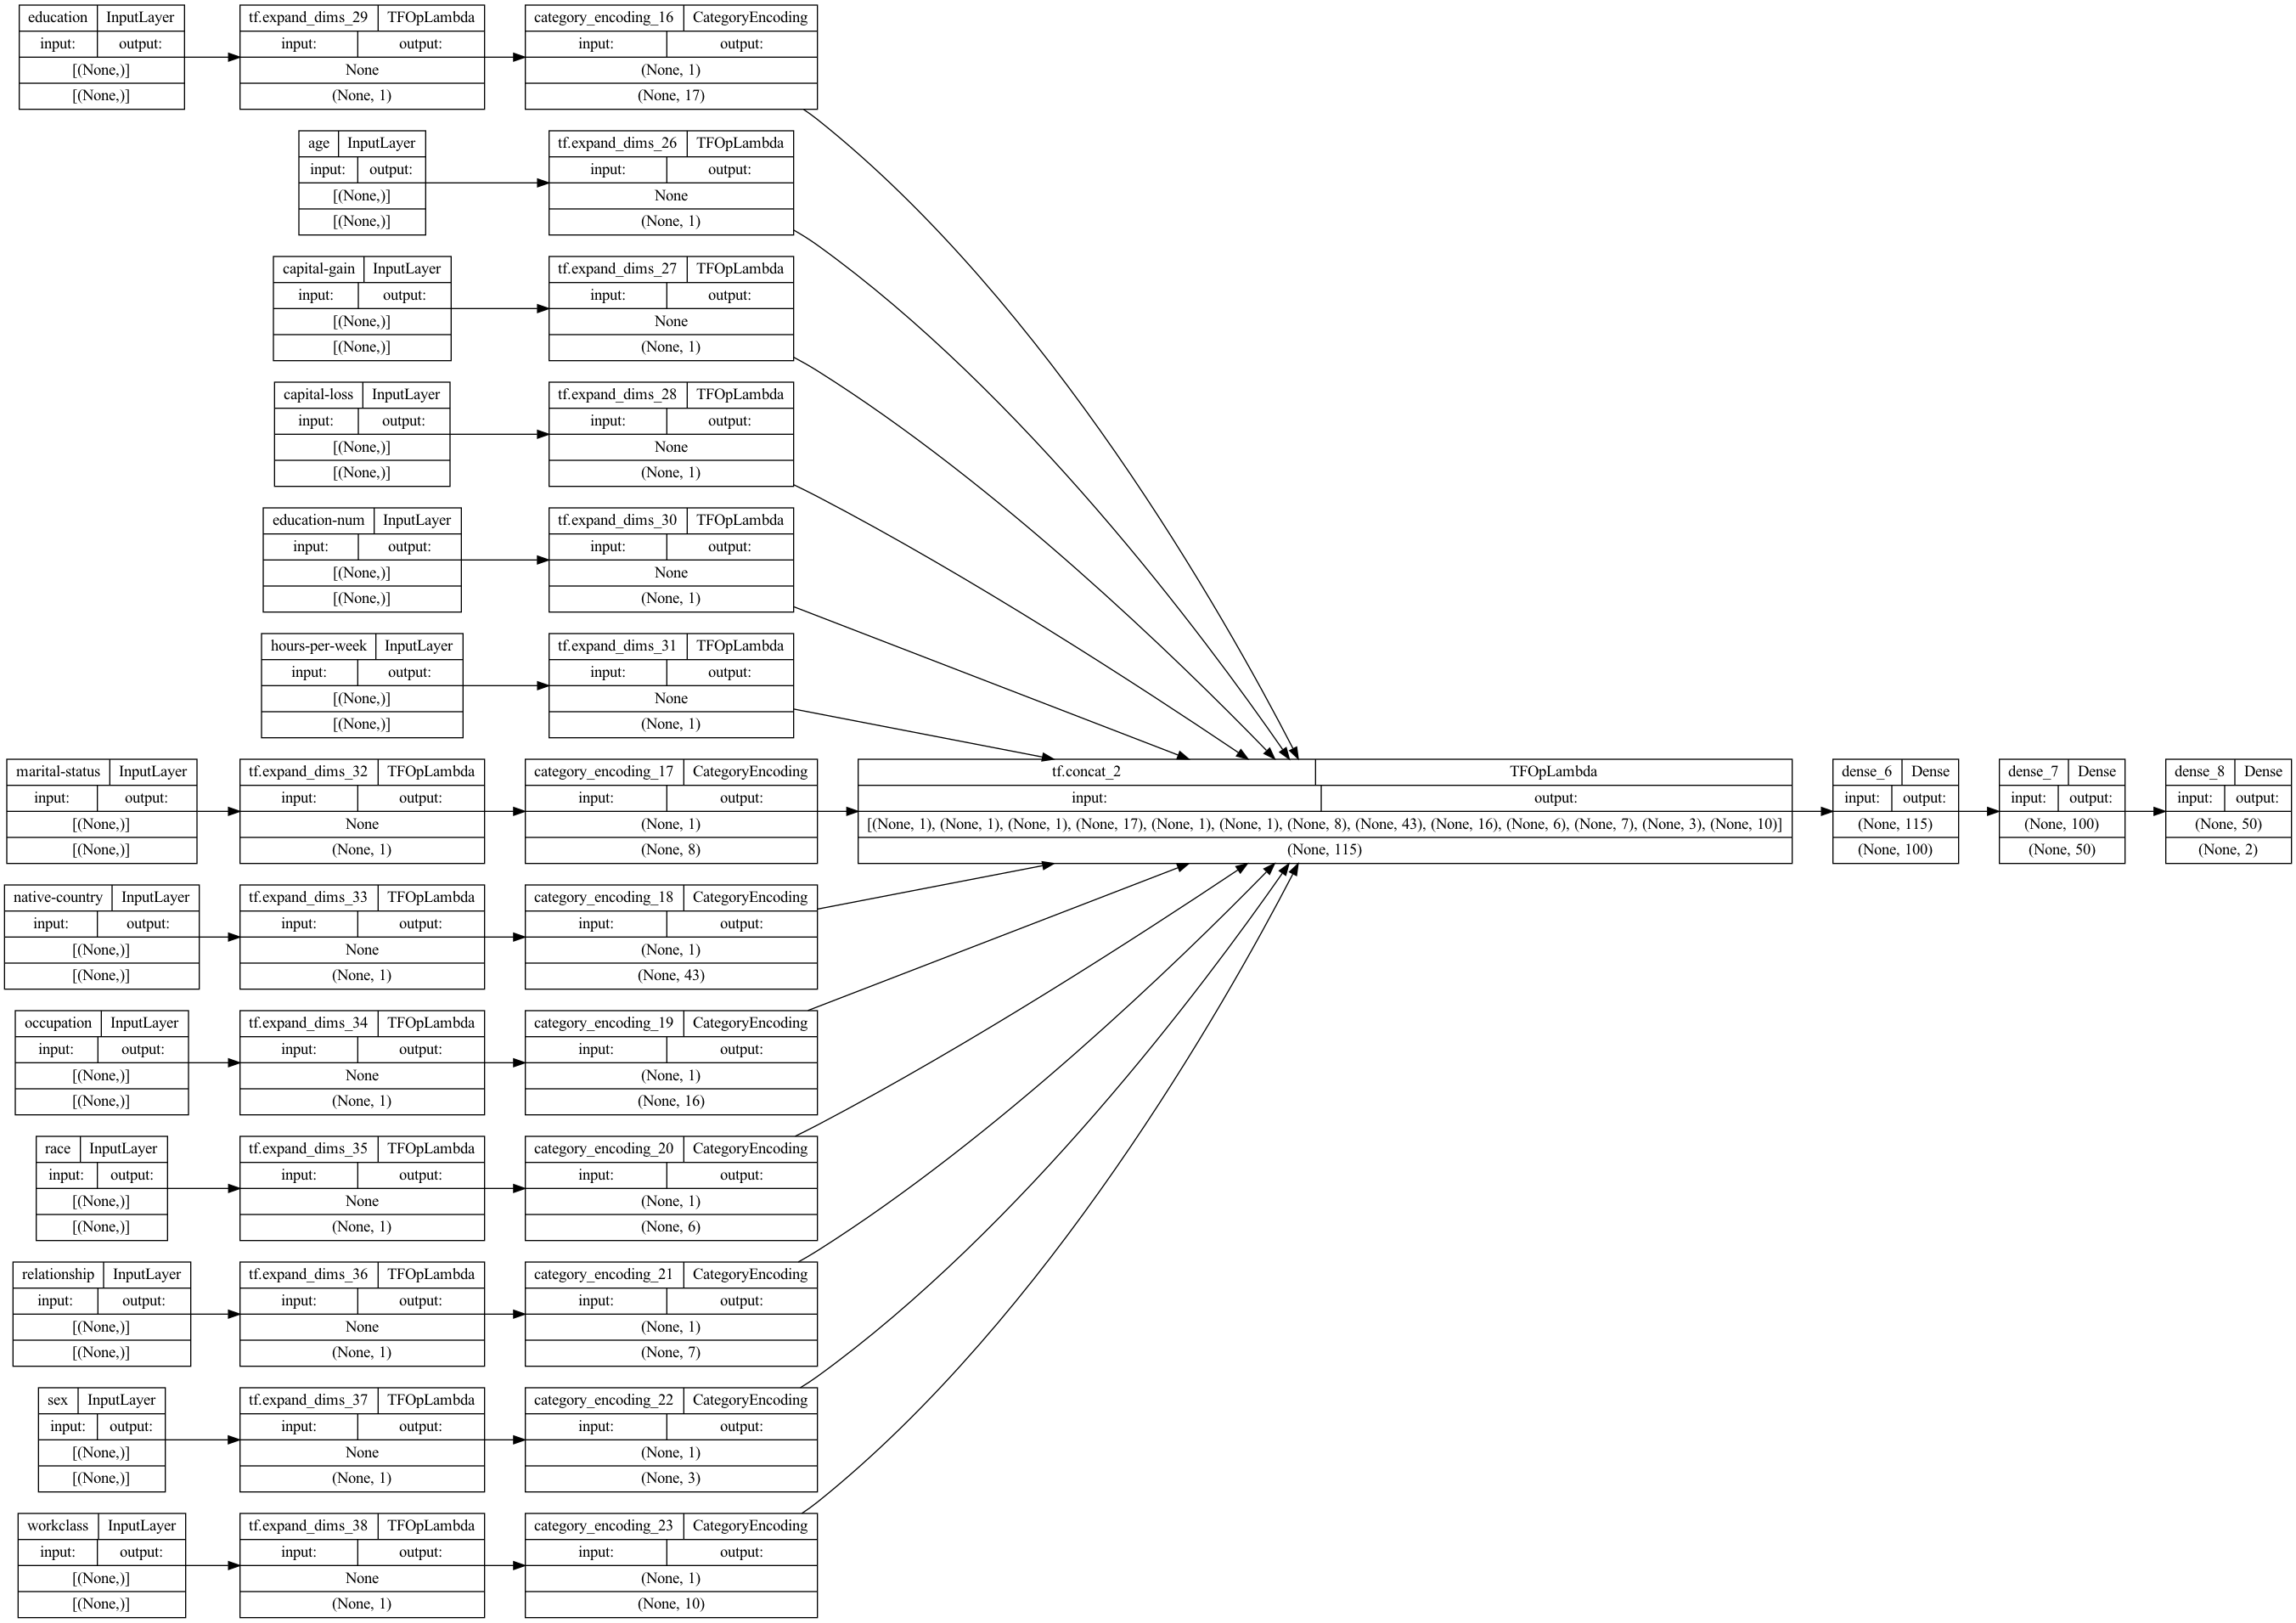

In [111]:
tf.keras.utils.plot_model(model, rankdir='LR', show_shapes=True)

---
Build the datasets

In [112]:
def get_dataset(working_dir, filebase, hp=hp):
    tf_transform_output = tft.TFTransformOutput(working_dir)
    
    data_path_pattern = os.path.join(working_dir, filebase+'*')
    
    input_fn = _make_training_input_fn(
        tf_transform_output,
        data_path_pattern,
        batch_size=hp.BATCH_SIZE
    )
    
    dataset = input_fn()
    
    return dataset

---
Train and evaluate the model

In [113]:
def train_and_evaluate(
    model,
    working_dir,
    hp=hp
):
    """Train the model on training data and evaluate on test data.
    
    Args:
        working_dir: The location of the Transform output.
        num_train_instances: Number of instances in train set
        num_test_instances: Number of instances in test set
        
    Returns: 
        The results from the estimator's 'evaluate' method
    """
    
    train_dataset = get_dataset(working_dir, hp.TRANSFORMED_TRAIN_DATA_FILEBASE, hp)
    validation_dataset = get_dataset(working_dir, hp.TRANSFORMED_TEST_DATA_FILEBASE, hp)

    model = build_keras_model(working_dir)
    
    history = train_model(
        model, 
        train_dataset, 
        validation_dataset
    )
    
    metric_values = model.evaluate(
        validation_dataset,
        steps=hp.EVALUATION_STEPS,
        return_dict=True,
        verbose=2
    )
    
    return model, history, metric_values

In [114]:
def train_model(model, train_dataset, validation_dataset, hp=hp):
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=hp.TRAIN_NUM_EPOCHS,
        steps_per_epoch=hp.STEPS_PER_TRAIN_EPOCH,
        validation_steps=hp.EVALUATION_STEPS,
        verbose=2
    )
    
    return history

In [115]:
model, history, metric_values = train_and_evaluate(model, output_dir)

Epoch 1/20
26/26 - 2s - loss: 0.5145 - accuracy: 0.7512 - val_loss: 0.4272 - val_accuracy: 0.7680 - 2s/epoch - 66ms/step
Epoch 2/20
26/26 - 0s - loss: 0.4191 - accuracy: 0.7963 - val_loss: 0.3761 - val_accuracy: 0.8281 - 435ms/epoch - 17ms/step
Epoch 3/20
26/26 - 0s - loss: 0.3760 - accuracy: 0.8254 - val_loss: 0.3608 - val_accuracy: 0.8327 - 421ms/epoch - 16ms/step
Epoch 4/20
26/26 - 0s - loss: 0.3693 - accuracy: 0.8308 - val_loss: 0.3551 - val_accuracy: 0.8345 - 473ms/epoch - 18ms/step
Epoch 5/20
26/26 - 1s - loss: 0.3436 - accuracy: 0.8480 - val_loss: 0.3483 - val_accuracy: 0.8373 - 519ms/epoch - 20ms/step
Epoch 6/20
26/26 - 1s - loss: 0.3404 - accuracy: 0.8459 - val_loss: 0.3464 - val_accuracy: 0.8370 - 502ms/epoch - 19ms/step
Epoch 7/20
26/26 - 0s - loss: 0.3461 - accuracy: 0.8356 - val_loss: 0.3435 - val_accuracy: 0.8400 - 465ms/epoch - 18ms/step
Epoch 8/20
26/26 - 1s - loss: 0.3516 - accuracy: 0.8347 - val_loss: 0.3573 - val_accuracy: 0.8369 - 504ms/epoch - 19ms/step
Epoch 9/20


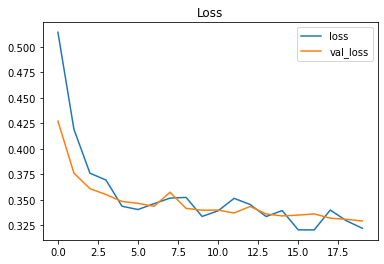

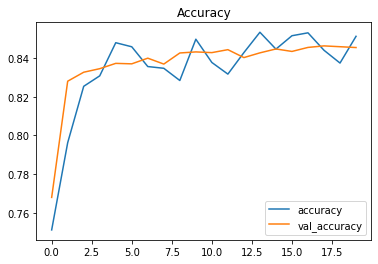

In [116]:
hist_keys = history.history.keys() # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
hist_df = pd.DataFrame(history.history) 

hist_df[['loss', 'val_loss']].plot(title="Loss")
hist_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.show()

<a id='6.3'></a><a name='6.3'></a>
## 6.3 Transform new data
<a href="#top">[back to top]</a>

In the previous section, the training process used hard-copies of the transformed data that were generated by `tft_beam.AnalyzeAndTransformDataset` in the `transform_dataset` function.

For operating on new data, you'll need to load the final version of the `preprocessing_fn` SavedModel from the output directory.

Here's a function to load new, unprocessed batches from a source file:

In [117]:
def read_csv(file_name, batch_size):
    # Reads CSV files into a dataset.
    return tf.data.experimental.make_csv_dataset(
        file_pattern=file_name,
        batch_size=batch_size, # default: 1024
        column_names=ORDERED_CSV_COLUMNS,
        column_defaults=COLUMN_DEFAULTS,
        prefetch_buffer_size=0,
        ignore_errors=True,
        shuffle=True, # default is True
        shuffle_buffer_size=1000, # default is 10_000
    )

In [118]:
# Get a single batch of data
for ex in read_csv(test_path, batch_size=5).take(1):
    break # can also use pass
    
pd.DataFrame(ex).T

,0,1,2,3,4
age,25.0,24.0,27.0,24.0,28.0
workclass,b' Private',b' Private',b' Self-emp-inc',b' Private',b' Private'
fnlwgt,189334.0,321435.0,214974.0,194630.0,226089.0
education,b' 11th',b' Bachelors',b' HS-grad',b' Bachelors',b' 10th'
education-num,7.0,13.0,9.0,13.0,6.0
marital-status,b' Married-civ-spouse',b' Married-civ-spouse',b' Married-civ-spouse',b' Never-married',b' Never-married'
occupation,b' Transport-moving',b' Farming-fishing',b' Craft-repair',b' Prof-specialty',b' Machine-op-inspct'
relationship,b' Husband',b' Husband',b' Husband',b' Not-in-family',b' Unmarried'
race,b' White',b' White',b' White',b' White',b' White'
sex,b' Male',b' Male',b' Male',b' Male',b' Female'


In [119]:
# double-checking via Pandas. This is non-shuffling!
df_test = pd.read_csv(test_path, names=ORDERED_CSV_COLUMNS, skiprows=1)
df_test.head(2).T

,0,1
age,25,38
workclass,Private,Private
fnlwgt,226802,89814
education,11th,HS-grad
education-num,7,9
marital-status,Never-married,Married-civ-spouse
occupation,Machine-op-inspct,Farming-fishing
relationship,Own-child,Husband
race,Black,White
sex,Male,Male


---
Load the `tft.TransformFeaturesLayer` to transform this data with `preprocessing_fn`.


    tft.TransformFeaturesLayer(
        tft_output: tft.TFTransformOutput,
        exported_as_v1: Optional[bool] = None
    )

https://www.tensorflow.org/tfx/transform/api_docs/python/tft/TransformFeaturesLayer

---

tft.TFTransformOutput 

A wrapper around the output of the tf.Transform.

    tft.TFTransformOutput(
        transform_output_dir: str
    )
    
https://www.tensorflow.org/tfx/transform/api_docs/python/tft/TFTransformOutput

In [120]:
ex2 = ex.copy()

# remove column fnlwgt, which is the number of people each row in the data represents
ex2.pop('fnlwgt')

# A Keras layer for applying a tf.Transform output to input layers.
# Returns output tensors
# https://www.tensorflow.org/tfx/transform/api_docs/python/tft/TransformFeaturesLayer
tft_layer = tf_transform_output.transform_features_layer()
print(f"tft_layer type: {type(tft_layer)}")

t_ex = tft_layer(ex2)
label = t_ex.pop(LABEL_KEY)

print(f"t_ex type: {(type(t_ex))}")
HR()

print(f"label:\n{label}")

tft_layer type: <class 'tensorflow_transform.output_wrapper.TransformFeaturesLayer'>
t_ex type: <class 'dict'>
----------------------------------------
label:
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [121]:
pd.DataFrame(t_ex).head().T

,0,1,2,3,4
race,0.000000,0.000000,0.000000,0.000000,0.000000
capital-loss,0.000000,0.000000,0.000000,0.000000,0.000000
hours-per-week,0.397959,0.346939,0.602041,0.346939,0.397959
occupation,8.000000,10.000000,1.000000,0.000000,6.000000
education-num,0.400000,0.800000,0.533333,0.800000,0.333333
relationship,0.000000,0.000000,0.000000,1.000000,3.000000
age,0.109589,0.095890,0.136986,0.095890,0.150685
sex,0.000000,0.000000,0.000000,0.000000,1.000000
workclass,0.000000,0.000000,5.000000,0.000000,0.000000
capital-gain,0.000000,0.000000,0.000000,0.000000,0.000000


---
The `tft_layer` is smart enough to still execute the transformation if only a subset of features are passed in. For example, if you only pass in two features, you'll get just the transformed version of those features back.

In [122]:
ex2 = pd.DataFrame(ex)[['education', 'hours-per-week']]
ex2

,education,hours-per-week
0,b' 11th',40.0
1,b' Bachelors',35.0
2,b' HS-grad',60.0
3,b' Bachelors',35.0
4,b' 10th',40.0


In [123]:
# Pass ex2 to tft_layer, and get back transformed versions
pd.DataFrame(tft_layer(dict(ex2)))

,hours-per-week,education
0,0.397959,5
1,0.346939,2
2,0.602041,0
3,0.346939,2
4,0.397959,7


---
This is a more robust version that:

1. Drops features that are not in `RAW_DATA_FEATURE_SPEC`
2. Applies `tf_transform_output.transform_features_layer` to create transformed features
3. Returns a `(features, label)` pair if the label is in the provided features.

In [124]:
# Inherits from parent class tf.Module, the Base neural network module class.
class Transform(tf.Module):
    def __init__(self, working_dir):
        self.working_dir = working_dir
        self.tf_transform_output = tft.TFTransformOutput(working_dir)
        self.tft_layer = tf_transform_output.transform_features_layer()
        
    # Turn this into a callable, eg Transform(file_location)
    @tf.function
    def __call__(self, features):
        raw_features = {}
        
        # 1. Drops features that are not in the feature-spec
        for key, val in features.items():
            # Skip unused keys
            if key not in RAW_DATA_FEATURE_SPEC:
                continue
            
            raw_features[key] = val
        
        # 2. Apply the `preprocessing_fn`
        transformed_features = tft_layer(raw_features)
        
        # 3. Returns a (features, label) pair if the label is in the provided features.
        if LABEL_KEY in transformed_features:
            # Pop the label and return a (features, labels) pair
            data_labels = transformed_features.pop(LABEL_KEY)
            return (transformed_features, data_labels)
        else:
            return transformed_features   

In [125]:
transform = Transform(output_dir)

In [126]:
t_ex, t_label = transform(ex)
print(type(t_ex))
print(type(t_label))

<class 'dict'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [127]:
pd.DataFrame(t_ex)

,race,capital-loss,hours-per-week,occupation,education-num,relationship,age,sex,workclass,capital-gain,education,native-country,marital-status
0,0,0.0,0.397959,8,0.400000,0,0.109589,0,0,0.0,5,0,0
1,0,0.0,0.346939,10,0.800000,0,0.095890,0,0,0.0,2,0,0
2,0,0.0,0.602041,1,0.533333,0,0.136986,0,5,0.0,0,0,0
3,0,0.0,0.346939,0,0.800000,1,0.095890,0,0,0.0,2,0,1
4,0,0.0,0.397959,6,0.333333,3,0.150685,1,0,0.0,7,0,1


---
Now you can use `Dataset.map` to apply that transformation dynamically to new data:

In [128]:
eval_result = model.evaluate(
    # Load new, unprocessed batches from a source file
    read_csv(test_path, batch_size=5).map(transform),
    steps = hp.EVALUATION_STEPS,
    return_dict = True,
    verbose=2
)

HR()

eval_result

128/128 - 1s - loss: 0.3187 - accuracy: 0.8391 - 991ms/epoch - 8ms/step
----------------------------------------


{'loss': 0.31870660185813904, 'accuracy': 0.839062511920929}

In [129]:
test_original = read_csv(test_path, batch_size=1)#.map(transform)

for x in test_original.take(1):
    pp.pprint(x)

OrderedDict([ ( 'age',
                <tf.Tensor: shape=(1,), dtype=float32, numpy=array([50.], dtype=float32)>),
              ( 'workclass',
                <tf.Tensor: shape=(1,), dtype=string, numpy=array([b' Self-emp-inc'], dtype=object)>),
              ( 'fnlwgt',
                <tf.Tensor: shape=(1,), dtype=float32, numpy=array([145714.], dtype=float32)>),
              ( 'education',
                <tf.Tensor: shape=(1,), dtype=string, numpy=array([b' HS-grad'], dtype=object)>),
              ( 'education-num',
                <tf.Tensor: shape=(1,), dtype=float32, numpy=array([9.], dtype=float32)>),
              ( 'marital-status',
                <tf.Tensor: shape=(1,), dtype=string, numpy=array([b' Married-civ-spouse'], dtype=object)>),
              ( 'occupation',
                <tf.Tensor: shape=(1,), dtype=string, numpy=array([b' Exec-managerial'], dtype=object)>),
              ( 'relationship',
                <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'

In [130]:
test_transfomed = read_csv(test_path, batch_size=5).map(transform)

for x in test_transfomed.take(1):
    pp.pprint(x)

( { 'age': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0.603, 0.068, 0.055, 0.068, 0.288], dtype=float32)>,
    'capital-gain': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
    'capital-loss': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
    'education': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 0,  1, 13,  0,  2])>,
    'education-num': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0.533, 0.6  , 0.133, 0.533, 0.8  ], dtype=float32)>,
    'hours-per-week': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0.398, 0.194, 0.378, 0.378, 0.398], dtype=float32)>,
    'marital-status': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 1, 0, 2])>,
    'native-country': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 1, 0, 0])>,
    'occupation': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([7, 3, 6, 4, 3])>,
    'race': <tf.Tensor: shape=(5,), dtype=int64, numpy=

<a id='6.4'></a><a name='6.4'></a>
## 6.4 Export the model
<a href="#top">[back to top]</a>

Now we have a trained model, and a method to apply the `preprocessing_fn` to new data. Assemble them into a new model that accepts serialized `tf.train.Example` protos as input.

In [131]:
class ServingModel(tf.Module):
    def __init__(self, model, working_dir):
        self.model = model
        self.working_dir = working_dir
        self.transform = Transform(working_dir)
        
    # Create a callable
    @tf.function(input_signature=[tf.TensorSpec(shape=[None], dtype=tf.string)])
    def __call__(self, serialized_tf_examples):
        
        # parse the tf.train.Example
        feature_spec = RAW_DATA_FEATURE_SPEC.copy()
        feature_spec.pop(LABEL_KEY)
        parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)
        
        # Apply the `preprocessing_fn`
        transformed_features = self.transform(parsed_features)
        
        # Run the model
        outputs = self.model(transformed_features)
        
        # Format the output
        classes_names = tf.constant([['0', '1']])
        classes = tf.tile(classes_names, [tf.shape(outputs)[0],1])
        return {'classes': classes, 'scores': outputs}
    
    
    def export(self, output_dir):
        
        # Increment the directory number. This is required in order to make this
        # model servable with model server
        save_model_dir = pathlib.Path(output_dir)/'model'
        number_dirs = [int(p.name) for p in save_model_dir.glob('*')
                      if p.name.isdigit()]
        id = max([0] + number_dirs)+1
        save_model_dir = save_model_dir/str(id)
        
        # Set the signature to make it visible for serving
        concrete_serving_fn = self.__call__.get_concrete_function()
        signatures = {'serving_default': concrete_serving_fn}
        
        # Export the model
        tf.saved_model.save(
            self,
            str(save_model_dir),
            signatures=signatures
        )
    
        return save_model_dir

---
Build the model and test-run it on the batch of serialized examples.

In [132]:
serving_model = ServingModel(model, output_dir)

serving_model(serialized_example_batch)

{'classes': <tf.Tensor: shape=(3, 2), dtype=string, numpy=
 array([[b'0', b'1'],
        [b'0', b'1'],
        [b'0', b'1']], dtype=object)>,
 'scores': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-1.742,  1.446],
        [-0.191,  0.178],
        [-1.829,  1.929]], dtype=float32)>}

---
Export the model as a SavedModel

In [133]:
saved_model_dir = serving_model.export(output_dir)
saved_model_dir

PosixPath('chp13_tfx_output/model/1')

---
Reload the model and test it on the same batch of examples:

In [134]:
reloaded = tf.saved_model.load(str(saved_model_dir))

In [135]:
run_model = reloaded.signatures['serving_default']

In [136]:
run_model(serialized_example_batch)

{'scores': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-1.742,  1.446],
        [-0.191,  0.178],
        [-1.829,  1.929]], dtype=float32)>,
 'classes': <tf.Tensor: shape=(3, 2), dtype=string, numpy=
 array([[b'0', b'1'],
        [b'0', b'1'],
        [b'0', b'1']], dtype=object)>}

---
<a id='7.0'></a><a name='7.0'></a>
# 7. What we did
<a href="#top">[back to top]</a>

In this notebook example, we used `tf.Transform` to preprocess a dataset of census data, and train a model with the cleaned and transformed data.

We also created an input function that we could use when we deploy our trained model in a production environment to perform inference.

By using the same code for both training and inference, we avoid any issues with data skew. 

Along the way, we learned about creating an Apache Beam transform to perform the transformation that we needed for cleaning the data. 

We also saw how to use this transformed data to train a model using `tf.keras`.